co-lab link: https://colab.research.google.com/drive/1hk6ILV70d3hJovA3n6KJ3IXHAiLW9ZqQ?usp=sharing

google slides link: https://docs.google.com/presentation/d/1i_zAmoAfhKzC-slW-pE5eF2Uj8_q4S15FSB6yBWdJkQ/edit?usp=sharing

### Problem 1.1.

Popular Video Games 1980 - 2023 🎮
https://www.kaggle.com/datasets/arnabchaki/popular-video-games-1980-2023

This dataset contains different game names and summaries, their developer team, their genres, their first version release dates, their average ratings, their times listed by users, their number of reviews, and user reviews.

I want to know what games/genres are the most popular over time, and if other factors influence the results (release time?...). And continuing off, I want to see if there is a pattern to a 'popular' game - what is popular when it first came out might not consistently carry on the success, vice versa.

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
uploaded = files.upload()

Saving W7games.csv to W7games.csv


In [5]:
import pandas as pd
df = pd.read_csv("W7games.csv")
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


# **2. Clean, Organize & Explore**

## **Problem 2.1.**

In [6]:
df.isnull().sum()

,0
Title,0
Release Date,0
Team,1
Rating,13
Times Listed,0
Number of Reviews,0
Genres,0
Summary,1
Reviews,0
Plays,0


In [7]:
# clean out NaNs - dropping rows with any missing values
df = df.dropna()

# remove [], '', and ""
df['Team'] = df['Team'].astype(str).str.replace(r'[\[\]\']', '', regex=True).str.strip()
df['Genres'] = df['Genres'].astype(str).str.replace(r'[\[\]\']', '', regex=True).str.strip()
df['Reviews'] = df['Reviews'].astype(str).str.replace(r'[\[\]\'"]', '', regex=True).str.strip()

# convert columns with 'K' to numerical
cols_to_convert = ['Times Listed', 'Number of Reviews', 'Plays', 'Playing', 'Backlogs', 'Wishlist']
for col in cols_to_convert:
    # Convert to string to handle potential non-string types
    df[col] = df[col].astype(str)
    # Check if the value ends with 'K' before multiplying and handle potential conversion errors
    df[col] = df[col].apply(lambda x: float(x.replace('K', '')) * 1000 if x.endswith('K') else pd.to_numeric(x, errors='coerce'))

# Ensure all columns are numeric after conversion
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert 'Release Date' to datetime objects, coercing errors to NaT (Not a Time) - re-adding this here as dropping NaNs happened before this in the previous flow
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Re-calculate Release Year after dropping NaNs
df['Release Year'] = df['Release Date'].dt.year

In [8]:
# Convert 'Release Date' to datetime objects, coercing errors to NaT (Not a Time)
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Check for missing values (NaT will be considered null)
missing_release_dates = df['Release Date'].isnull().sum()

print(f"Number of missing values in 'Release Date' after conversion: {missing_release_dates}")

# Check if any Release Year is 0 after conversion (unlikely but as per user request)
# First, extract the year, which will be NaN for NaT dates
df['Release Year'] = df['Release Date'].dt.year
zero_release_years = (df['Release Year'] == 0).sum()

print(f"Number of games with Release Year of 0: {zero_release_years}")

Number of missing values in 'Release Date' after conversion: 2
Number of games with Release Year of 0: 0


In [9]:
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist,Release Year
0,Elden Ring,2022-02-25,"Bandai Namco Entertainment, FromSoftware",4.5,3900.0,3900.0,"Adventure, RPG","Elden Ring is a fantasy, action and open world...",The first playthrough of elden ring is one of ...,17000.0,3800.0,4600.0,4800.0,2022.0
1,Hades,2019-12-10,Supergiant Games,4.3,2900.0,2900.0,"Adventure, Brawler, Indie, RPG",A rogue-lite hack and slash dungeon crawler in...,convinced this is a roguelike for people who d...,21000.0,3200.0,6300.0,3600.0,2019.0
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"Nintendo, Nintendo EPD Production Group No. 3",4.4,4300.0,4300.0,"Adventure, RPG",The Legend of Zelda: Breath of the Wild is the...,This game is the game (that is not CS:GO) that...,30000.0,2500.0,5000.0,2600.0,2017.0
3,Undertale,2015-09-15,"tobyfox, 8-4",4.2,3500.0,3500.0,"Adventure, Indie, RPG, Turn Based Strategy","A small child falls into the Underground, wher...",soundtrack is tied for #1 with nier automata. ...,28000.0,679.0,4900.0,1800.0,2015.0
4,Hollow Knight,2017-02-24,Team Cherry,4.4,3000.0,3000.0,"Adventure, Indie, Platform",A 2D metroidvania with an emphasis on close co...,"this games worldbuilding is incredible, with i...",21000.0,2400.0,8300.0,2300.0,2017.0


## **Problem 2.2.**

In [10]:
# mean, median, mode and standard deviation for quantitative continuous data
numerical_columns = ['Rating', 'Times Listed', 'Number of Reviews', 'Plays', 'Playing', 'Backlogs', 'Wishlist']

mean_values = df[numerical_columns].mean()
median_values = df[numerical_columns].median()
mode_values = df[numerical_columns].mode().iloc[0]
std_dev_values = df[numerical_columns].std()

print("Mean values:\n", mean_values)
print("\nMedian values:\n", median_values)
print("\nMode values:\n", mode_values)
print("\nStandard Deviation values:\n", std_dev_values)

Mean values:
 Rating                  3.720027
Times Listed          775.156876
Number of Reviews     775.156876
Plays                6311.834446
Playing               269.855808
Backlogs             1463.375167
Wishlist              778.184913
dtype: float64

Median values:
 Rating                  3.8
Times Listed          555.0
Number of Reviews     555.0
Plays                4300.0
Playing               115.0
Backlogs             1000.0
Wishlist              496.0
dtype: float64

Mode values:
 Rating                   4.1
Times Listed          1100.0
Number of Reviews     1100.0
Plays                12000.0
Playing               1100.0
Backlogs              1500.0
Wishlist              1300.0
Name: 0, dtype: float64

Standard Deviation values:
 Rating                  0.532133
Times Listed          688.335864
Number of Reviews     688.335864
Plays                5891.431835
Playing               427.668688
Backlogs             1342.977036
Wishlist              793.828103
dtype: flo

In [11]:
# Frequency counts for Genres
# Since 'Genres' is a string with comma-separated values, we need to split and count
genres_list = df['Genres'].str.split(', ').explode()
# Filter out empty strings
genres_list = genres_list[genres_list != '']
genre_counts = genres_list.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Frequency']
print("Frequency counts for Genres:")
display(genre_counts)

Frequency counts for Genres:


,Genre,Frequency
0,Adventure,1007
1,RPG,516
2,Shooter,351
3,Platform,329
4,Indie,283
5,Puzzle,175
6,Brawler,157
7,Strategy,142
8,Simulator,125
9,Turn Based Strategy,99


In [12]:
# Frequency counts for Team
# Since 'Team' is a string with comma-separated values, we need to split and count
team_list = df['Team'].str.split(', ').explode()
team_list = team_list[team_list != '']
team_counts = team_list.value_counts().reset_index()
team_counts.columns = ['Team', 'Frequency']
print("Frequency counts for Team:")
display(team_counts)

Frequency counts for Team:


,Team,Frequency
0,Nintendo,244
1,Capcom,89
2,Square Enix,77
3,Sega,63
4,Electronic Arts,58
...,...,...
655,Acid Nerve,1
656,Mundfish,1
657,Humble Bundle,1
658,Gears for Breakfast,1


In [13]:
# Frequency counts for Release Year
df['Release Year'] = pd.to_datetime(df['Release Date'], errors='coerce').dt.year
year_counts = df['Release Year'].value_counts().sort_index().reset_index()
year_counts.columns = ['Release Year', 'Frequency']
print("\nFrequency counts for Release Year:")
display(year_counts)


Frequency counts for Release Year:


,Release Year,Frequency
0,1980.0,1
1,1982.0,1
2,1985.0,1
3,1986.0,4
4,1987.0,3
5,1988.0,5
6,1989.0,5
7,1990.0,6
8,1991.0,11
9,1992.0,6


## **Problem 2.3.**

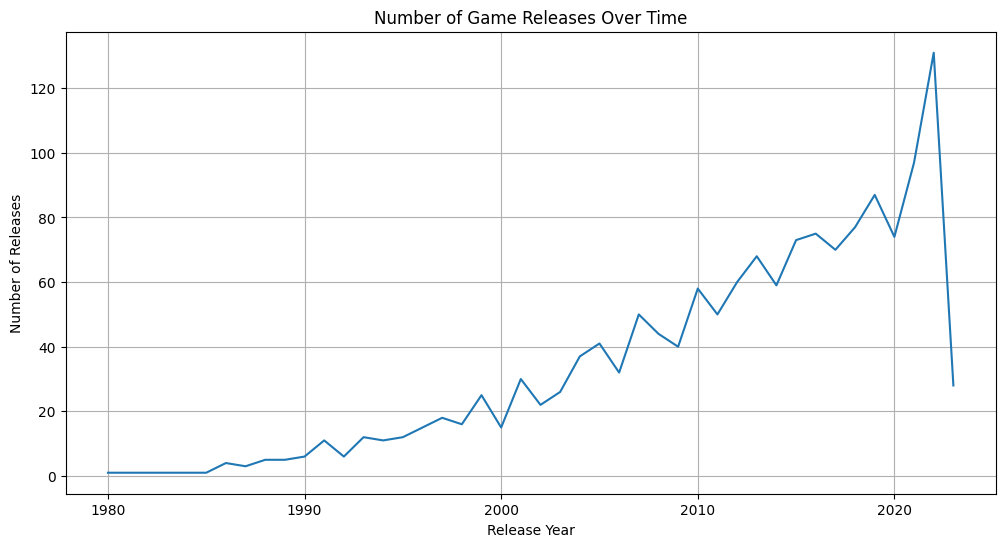

In [14]:
# Game Releases Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=year_counts, x='Release Year', y='Frequency')
plt.title('Number of Game Releases Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Releases')
plt.grid(True)
plt.show()

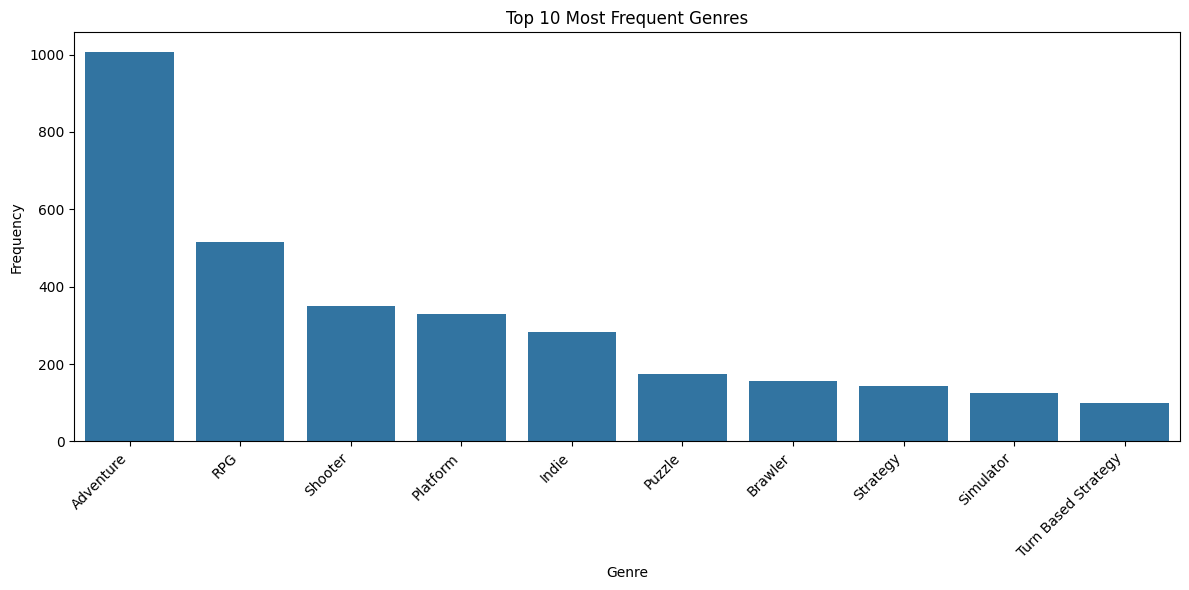

In [15]:
# Top Genres by Frequency
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_counts.head(10), x='Genre', y='Frequency')
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

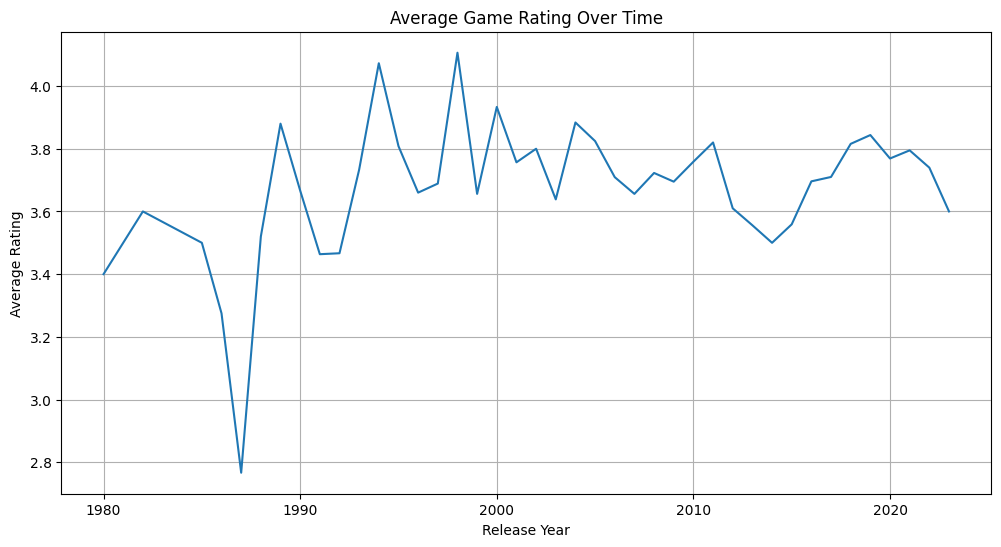

In [16]:
df['Release Year'] = pd.to_datetime(df['Release Date'], errors='coerce').dt.year

average_rating_per_year = df.groupby('Release Year')['Rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_rating_per_year, x='Release Year', y='Rating')
plt.title('Average Game Rating Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

In [17]:
%pip install wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 20 most common words in game reviews:


[('game', 5972),
 ('n', 4148),
 ('like', 1633),
 ('really', 1379),
 ('de', 1364),
 ('one', 1359),
 ('que', 1308),
 ('games', 1293),
 ('fun', 1227),
 ('good', 1225),
 ('e', 1052),
 ('time', 1039),
 ('story', 918),
 ('play', 910),
 ('much', 828),
 ('gameplay', 798),
 ('great', 797),
 ('played', 784),
 ('best', 780),
 ('still', 773)]

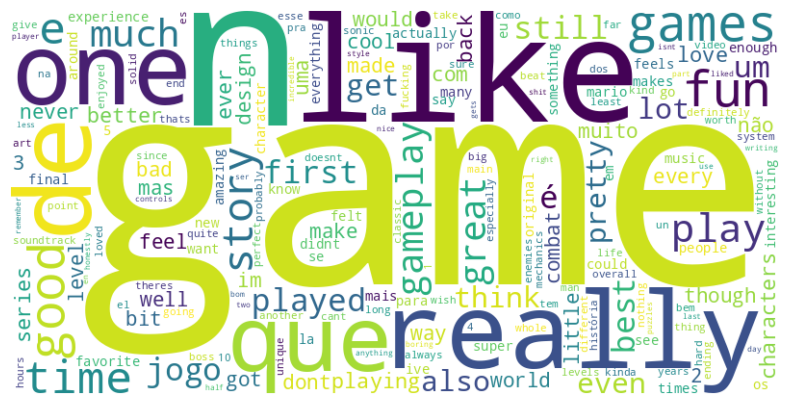

In [18]:
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))

# Combine all reviews into a single string
all_reviews = ' '.join(df['Reviews'].dropna().tolist())

# Tokenize the text and remove punctuation
words = re.findall(r'\b\w+\b', all_reviews.lower())

# Remove stop words
filtered_words = [word for word in words if word not in stopwords]
word_counts = Counter(filtered_words)

print("Top 20 most common words in game reviews:")
display(word_counts.most_common(20))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
%pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.1 MB/s eta 0:00:00


In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Perform sentiment analysis on the 'Reviews' column
df['VADER_Sentiment'] = df['Reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Assign sentiment label based on the compound score
def assign_vader_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Label'] = df['VADER_Sentiment'].apply(assign_vader_sentiment)

# Check results
display(df[['Reviews', 'VADER_Sentiment', 'Sentiment_Label']].head())

,Reviews,VADER_Sentiment,Sentiment_Label
0,The first playthrough of elden ring is one of ...,0.9977,Positive
1,convinced this is a roguelike for people who d...,0.9979,Positive
2,This game is the game (that is not CS:GO) that...,0.9481,Positive
3,soundtrack is tied for #1 with nier automata. ...,0.9880,Positive
4,"this games worldbuilding is incredible, with i...",0.9940,Positive


In [21]:
# Get the frequency counts for each sentiment label
sentiment_counts = df['Sentiment_Label'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Display the table
print("Sentiment Distribution:")
display(sentiment_counts)

Sentiment Distribution:


,Sentiment,Count
0,Positive,1294
1,Negative,200
2,Neutral,4


## **Problem 2.4.**

There is a spike in number of releases in more recent years (around 2022). Perhaps with the pandemic, there is a rise in-need for games and pastimes post-pandemic. Adventure, RPG, and Shooter games are the most prevalent genres in this dataset, which makes me wonder if this dataset is biased. On Kaggle, the author said it was scrapped from backloggd, which I believe is not a very popular platform for games like Steam or GOG (how likely is the data skewed towards these categories of games). The average game rating seems to stay around the same over time (more flucuations between 1985-2000 and a drop in around 1988, possibly because less data collected). From the word cloud, the repeatitve words are generally positive (fun, great, best, love...). The VADER sentiment analysis of the Reviews also shows that there are much more positive comments than negative ones, proving the high average rating seems to be right.

# **3. Inference**

## **Problem 3.1.**

H01: There is no difference in the average rating between games released before and after 2015.

Type I Error: There is a difference in average rating between games released before and after 2015 when there is actually no difference.

Type II Error: There is no difference in average rating between games released befroe and after 2015 when there is a difference.

Welch's T-test (compare data from 2 time periods)

Study Power: 80%

Statistical Significance Level: 0.05

In [22]:
# H01 MDE

from statsmodels.stats.power import TTestIndPower

alpha = 0.05  # Statistical significance level
power = 0.80  # Desired study power

# Split the dataframe into two groups based on release year
df_before_2015 = df[df['Release Year'] < 2015].copy()
df_after_2015 = df[df['Release Year'] >= 2015].copy()

n1 = len(df_before_2015)
n2 = len(df_after_2015)

# Pooled standard deviation (using the overall standard deviation of the 'Rating' column as an estimate)
std_dev = df['Rating'].std()

# Create power analysis object
power_analysis = TTestIndPower()

# calc MDE
mde_effect_size = power_analysis.solve_power(
    effect_size=None,
    nobs1=n1,
    alpha=alpha,
    power=power,
    ratio=n2/n1,
    alternative='two-sided'
)

# The MDE is the effect size multiplied by the standard deviation
mde_h01 = mde_effect_size * std_dev

print(f"Calculated MDE for H01 (Average Rating Before vs. After 2015): {mde_h01:.4f}")

Calculated MDE for H01 (Average Rating Before vs. After 2015): 0.0772


H02: The average popularity (times listed, number of reviews, and plays) is the same across all genres over time.

Type I Error: There is a difference with the average popularity across genres over time, but is actually the same.

Type II Error: There is no difference with the average popularity across genres over time, but is actually different.

ANOVA test

Study Power: 80%

Statistical Significance Level: 0.05

In [24]:
# H02 MDE
from statsmodels.stats.power import TTestIndPower
import pandas as pd

alpha = 0.05  # Statistical significance level
power = 0.80  # Desired study power

# Popularity metrics for H02
popularity_metrics = ['Times Listed', 'Number of Reviews', 'Plays']

# Prepare data for MDE calculation and ANOVA by exploding genres
# Use the original dataframe 'df' which should be available from previous cells
popularity_df = df.copy()
popularity_df['Genres'] = popularity_df['Genres'].str.split(', ')
popularity_df = popularity_df.explode('Genres')
popularity_df = popularity_df[popularity_df['Genres'] != '']


print("Minimum Detectable Effect (MDE) for H02:")

for metric in popularity_metrics:
    if popularity_df[metric].std() > 0:
        # Using a simplified approach based on a two-sample comparison for illustration
        # We'll use the average sample size per genre as a rough estimate for nobs1 and nobs2
        average_n_per_genre = len(popularity_df) / popularity_df['Genres'].nunique()

        # Ensure average_n_per_genre is an integer and greater than 1 for power calculation
        average_n_per_genre = int(average_n_per_genre)


        if average_n_per_genre > 1:
             power_analysis = TTestIndPower()
             mde_effect_size = power_analysis.solve_power(
                 effect_size=None,
                 nobs1=average_n_per_genre,
                 alpha=alpha,
                 power=power,
                 ratio=1.0, # Assuming equal sample size per group for this rough estimate
                 alternative='two-sided'
             )
             # Ensure mde_effect_size is a scalar before multiplication
             mde = mde_effect_size * popularity_df[metric].std()
             print(f"  - {metric}: Approximately {mde:.4f} (Simplified estimate)")
        else:
            print(f"  - {metric}: Not enough data per genre to estimate MDE.")

    else:
        print(f"  - {metric}: Standard deviation is zero, MDE is not applicable.")

Minimum Detectable Effect (MDE) for H02:
  - Times Listed: Approximately 221.0714 (Simplified estimate)
  - Number of Reviews: Approximately 221.0714 (Simplified estimate)
  - Plays: Approximately 1881.1710 (Simplified estimate)


## **Problem 3.2.**

In [25]:
# H01

from scipy.stats import shapiro

# Shapiro-Wilk test for normality on the 'Rating' column for games released before 2015
shapiro_before = shapiro(df_before_2015['Rating'])
print(f"Shapiro-Wilk test for 'Rating' (Before 2015): Statistic = {shapiro_before.statistic}, p-value = {shapiro_before.pvalue}")

# Shapiro-Wilk test for normality on the 'Rating' column for games released in 2015 or after
shapiro_after = shapiro(df_after_2015['Rating'])
print(f"Shapiro-Wilk test for 'Rating' (After 2015): Statistic = {shapiro_after.statistic}, p-value = {shapiro_after.pvalue}")

Shapiro-Wilk test for 'Rating' (Before 2015): Statistic = 0.939486439027029, p-value = 2.5269694119825294e-17
Shapiro-Wilk test for 'Rating' (After 2015): Statistic = 0.9419954287176799, p-value = 4.710654468487948e-16


Shapiro-Wilk test for before AND after 2015 are not normally distributed.

In [26]:
# H02

popularity_metrics = ['Times Listed', 'Number of Reviews', 'Plays']

print("Shapiro-Wilk test for normality of popularity metrics (H02):")

for metric in popularity_metrics:
    # Drop NaN values for the test
    metric_data = popularity_df[metric].dropna()

    if len(metric_data) > 5000:
        # Shapiro-Wilk test is not recommended for sample sizes over 5000
        print(f"  - {metric}: Sample size ({len(metric_data)}) is too large for Shapiro-Wilk test.")
    elif len(metric_data) > 3:
        shapiro_test = shapiro(metric_data)
        print(f"  - {metric}: Statistic = {shapiro_test.statistic}, p-value = {shapiro_test.pvalue}")
    else:
        print(f"  - {metric}: Sample size ({len(metric_data)}) is too small to perform Shapiro-Wilk test.")

Shapiro-Wilk test for normality of popularity metrics (H02):
  - Times Listed: Statistic = 0.822880785622581, p-value = 5.107568698419536e-53
  - Number of Reviews: Statistic = 0.822880785622581, p-value = 5.107568698419536e-53
  - Plays: Statistic = 0.8412133104615623, p-value = 3.817861881982268e-51


Shapiro-Wilk test for the popularity metrics are not normally distributed.

## **Problem 3.3.**

In [27]:
# H01

from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd

# Load and clean the data (copying from previous cells)
df = pd.read_csv("W7games.csv")
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()
df['Team'] = df['Team'].astype(str).str.replace(r'[\[\]\']', '', regex=True).str.strip()
df['Genres'] = df['Genres'].astype(str).str.replace(r'[\[\]\']', '', regex=True).str.strip()
df['Reviews'] = df['Reviews'].astype(str).str.replace(r'[\[\]\'"]', '', regex=True).str.strip()

cols_to_convert = ['Times Listed', 'Number of Reviews', 'Plays', 'Playing', 'Backlogs', 'Wishlist']
for col in cols_to_convert:
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: float(x.replace('K', '')) * 1000 if x.endswith('K') else pd.to_numeric(x, errors='coerce'))

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Year'] = df['Release Date'].dt.year

# Split the dataframe into two groups based on release year
df_before_2015 = df[df['Release Year'] < 2015].copy()
df_after_2015 = df[df['Release Year'] >= 2015].copy()

# Compare mean 'Rating' for games released before 2015 and games released in 2015 or after.
ttest_result = ttest_ind(df_before_2015['Rating'], df_after_2015['Rating'], equal_var=False)

print(f"Welchs t-test:")
print(f"  Test Statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# result in table
results_data = {
    'Test Name': ['Welchs t-test'],
    'Null Hypothesis': ['μ_before_2015 = μ_after_2015'],
    'Test Statistic': [ttest_result.statistic],
    'P-value': [ttest_result.pvalue]
}

results_df = pd.DataFrame(results_data)

# Add conclusion based on alpha = 0.05
results_df['Statistical Significance (Alpha=0.05)'] = results_df['P-value'].apply(lambda p: 'Statistically Significant' if p < 0.05 else 'Not Statistically Significant')
display(results_df)

Welchs t-test:
  Test Statistic: -1.4300
  P-value: 0.1529


,Test Name,Null Hypothesis,Test Statistic,P-value,Statistical Significance (Alpha=0.05)
0,Welchs t-test,μ_before_2015 = μ_after_2015,-1.430029,0.152924,Not Statistically Significant


In [29]:
#H02

from scipy.stats import f_oneway

popularity_metrics = ['Times Listed', 'Number of Reviews', 'Plays']

# Prepare data for ANOVA - create a list of arrays for each genre for each metric
anova_data = {}
for metric in popularity_metrics:
    anova_data[metric] = []
    for genre in popularity_df['Genres'].unique():
        genre_values = popularity_df[popularity_df['Genres'] == genre][metric].dropna()
        if len(genre_values) > 0:
            anova_data[metric].append(genre_values)

# ANOVA
anova_results = []
for metric in popularity_metrics:
    if len(anova_data[metric]) > 1:
        f_statistic, p_value = f_oneway(*anova_data[metric])
        anova_results.append({
            'Metric': metric,
            'F-statistic': f_statistic,
            'P-value': p_value,
            'Statistical Significance': 'Statistically Significant' if p_value < 0.05 else 'Not Statistically Significant'
        })
    else:
        anova_results.append({
            'Metric': metric,
            'F-statistic': None,
            'P-value': None,
            'Statistical Significance': 'Not enough data for ANOVA'
        })

anova_results_df = pd.DataFrame(anova_results)
display(anova_results_df)

,Metric,F-statistic,P-value,Statistical Significance
0,Times Listed,8.803603,1.476675e-28,Statistically Significant
1,Number of Reviews,8.803603,1.476675e-28,Statistically Significant
2,Plays,4.395135,3.633952e-11,Statistically Significant


In [31]:
# H02

# Calculate the average popularity metrics per genre
average_popularity_per_genre = popularity_df.groupby('Genres')[['Times Listed', 'Number of Reviews', 'Plays']].mean().reset_index()
average_popularity_per_genre.rename(columns={'Genres': 'Genre'}, inplace=True) # Rename column to 'Genre' for consistency with plotting cell

most_popular_times_listed = average_popularity_per_genre.sort_values(by='Times Listed', ascending=False).head(5)
most_popular_number_of_reviews = average_popularity_per_genre.sort_values(by='Number of Reviews', ascending=False).head(5)
most_popular_plays = average_popularity_per_genre.sort_values(by='Plays', ascending=False).head(5)

print("Top 5 Genres by Average Times Listed:")
display(most_popular_times_listed)

print("\nTop 5 Genres by Average Number of Reviews:")
display(most_popular_number_of_reviews)

print("\nTop 5 Genres by Average Plays:")
display(most_popular_plays)

Top 5 Genres by Average Times Listed:


,Genre,Times Listed,Number of Reviews,Plays
21,Turn Based Strategy,957.222222,957.222222,6834.181818
2,Brawler,935.477707,935.477707,6518.273885
13,RPG,881.872093,881.872093,6381.209302
0,Adventure,874.528302,874.528302,6591.593843
9,Platform,858.407295,858.407295,7162.522796



Top 5 Genres by Average Number of Reviews:


,Genre,Times Listed,Number of Reviews,Plays
21,Turn Based Strategy,957.222222,957.222222,6834.181818
2,Brawler,935.477707,935.477707,6518.273885
13,RPG,881.872093,881.872093,6381.209302
0,Adventure,874.528302,874.528302,6591.593843
9,Platform,858.407295,858.407295,7162.522796



Top 5 Genres by Average Plays:


,Genre,Times Listed,Number of Reviews,Plays
6,MOBA,417.666667,417.666667,10166.666667
16,Shooter,846.000000,846.000000,7565.726496
14,Racing,535.333333,535.333333,7197.000000
9,Platform,858.407295,858.407295,7162.522796
21,Turn Based Strategy,957.222222,957.222222,6834.181818


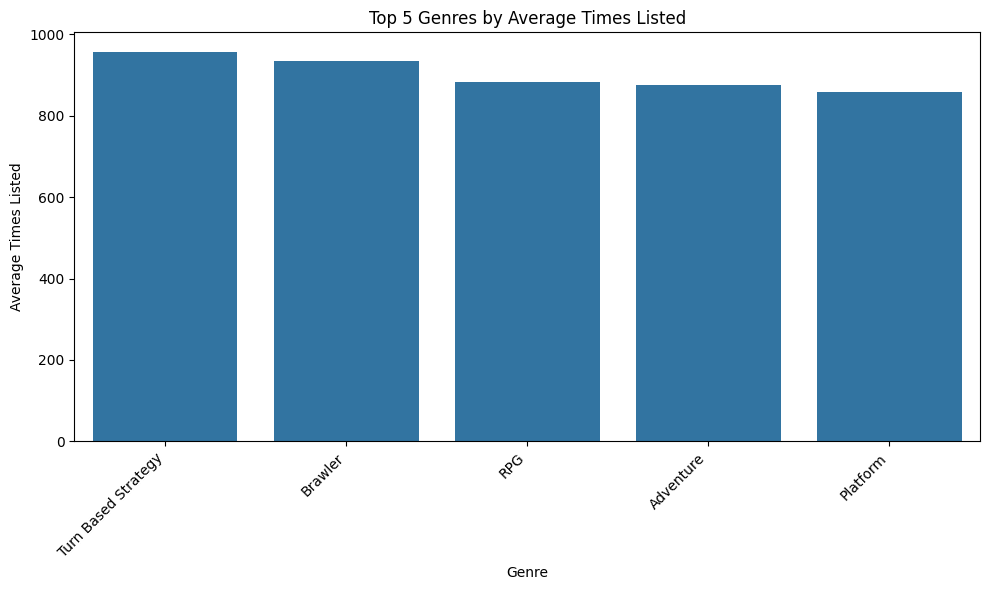

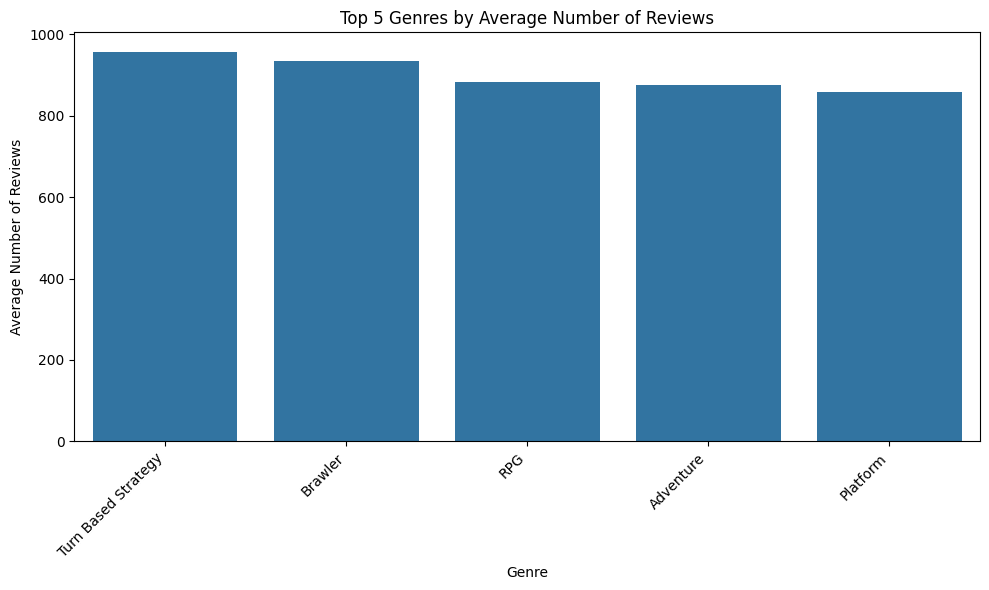

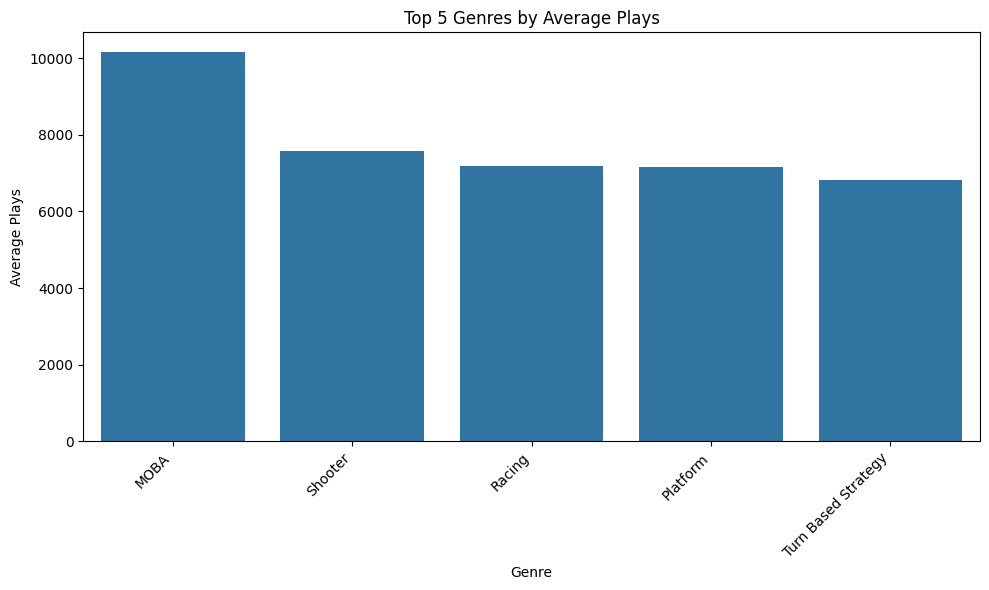

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by each popularity metric to find the top 5 genres
most_popular_times_listed = average_popularity_per_genre.sort_values(by='Times Listed', ascending=False).head(5)
most_popular_number_of_reviews = average_popularity_per_genre.sort_values(by='Number of Reviews', ascending=False).head(5)
most_popular_plays = average_popularity_per_genre.sort_values(by='Plays', ascending=False).head(5)

# Create bar plot for Top 5 Genres by Average Times Listed
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Times Listed', data=most_popular_times_listed)
plt.title('Top 5 Genres by Average Times Listed')
plt.xlabel('Genre')
plt.ylabel('Average Times Listed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create bar plot for Top 5 Genres by Average Number of Reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Number of Reviews', data=most_popular_number_of_reviews)
plt.title('Top 5 Genres by Average Number of Reviews')
plt.xlabel('Genre')
plt.ylabel('Average Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create bar plot for Top 5 Genres by Average Plays
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Plays', data=most_popular_plays)
plt.title('Top 5 Genres by Average Plays')
plt.xlabel('Genre')
plt.ylabel('Average Plays')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Problem 3.4.**

H01

The test statistic is -1.4300 shows the difference isn't big enough for the data to be statistically signigicant. As the p-value is less than 0.05, it again shows that we fail to reject the null hypothesis. There is no statistically significance with the average rating between the games released before and after 2015.

Risk of Type I Error: not at risk (already failed to reject)


Risk of Type II Error: is at risk (fail to detect a difference if it exists). The test had an 80% chance of detecting a true difference in means of at least 0.0772.

---

This shows that there is not a huge difference in game development or market trends around 2015 for the average rating to increase. This might be due to the standard for games increased on gamers' side, causing the game producers to also improve their dev and system. There might be an improvement overall but the rate stays the same. Also, there are much more data on games released after 2015, so there are more data points on the graphs-giving smoother lines instead of zigzag shaped line graph. With MDE being 0.0772, it's possible that there is a small significant difference that the test wasn't able to detect (risk of Type II error).

H02

The p-value for the ANOVA test is very small, very close to zero (reject the null hypothesis for all of the popularity metrics - Times Listed, Number of Reviews, and Plays). This shows that the average popularity is not the same across all genres over time (there is statistical significance).

Risk of type I error: is at risk (very low due to low p-value). There are significant differences in popularity, but there is none.

Risk of type II error: not at risk (rejected null hypothesis)

---

In general, not all genres are equally popular over time. The genres with higher average popularity might have more customers and more crowded, meaning a start-up will need to be more innovative in order to stand out. Less popular genres might have more opportunities for new ideas and approaches. There is also technological aspect, where there is limitations with older games (being only able to play on PC). Now, many games are accessible with mobile platforms and/or laptops. This can also impact the popularity of certain games in different genres.

## **Problem 3.5.**

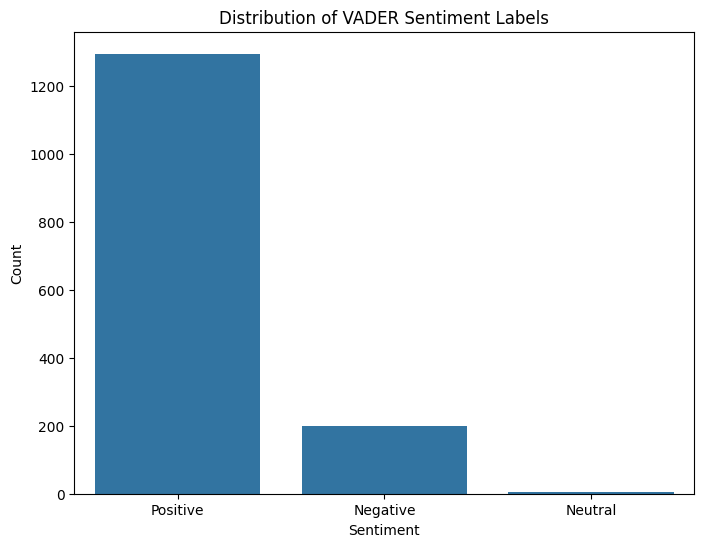

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot of the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts)
plt.title('Distribution of VADER Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

The VADER sentiment of the game reviews is generally positive, which aligns with the high average rating over time. Even though the quantitative test didn't have a statistical significance for before and affter 2015, the qualitative analysis shows that the overall sentiment is positive regardless of the release time with the t-test. Without this significant difference in average rating might be because there is a consistant high-performance with similar user groups.

As I mentioned previously, words like fun, good, best frequently showed up in the word cloud, supporting the positive sentiment value (there is almost no negative words). With the overall positive reviews, even though the statistical tests show no difference before and after 2015, the base data is very much skewed towards positive feedback.

Furthoremore with H02, the qualitative data also supports it. Though the sentiment value doesn't tell us exactly why certain genres are more popular, but it shows that within the popular games, the experience of playing these games are positive.

In [35]:
#H02

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

genres_of_interest = ['Turn Based Strategy', 'Brawler', 'RPG', 'Adventure', 'Platform', 'MOBA', 'Shooter', 'Racing']
df_filtered_genres = popularity_df[popularity_df['Genres'].isin(genres_of_interest)].copy()

# Ensure the 'Reviews' column is treated as string and handle potential NaNs
df_filtered_genres['Reviews'] = df_filtered_genres['Reviews'].astype(str).fillna('')

# Perform sentiment analysis on the 'Reviews' column for the filtered data
df_filtered_genres['VADER_Sentiment'] = df_filtered_genres['Reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Assign sentiment label based on the compound score
def assign_vader_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_filtered_genres['Sentiment_Label'] = df_filtered_genres['VADER_Sentiment'].apply(assign_vader_sentiment)

# Group by genre and sentiment label to get counts
genre_sentiment_counts = df_filtered_genres.groupby(['Genres', 'Sentiment_Label']).size().unstack(fill_value=0)
genre_sentiment_counts.index.name = 'Genre'

print("VADER Sentiment Distribution per Genre:")
display(genre_sentiment_counts)

VADER Sentiment Distribution per Genre:


Sentiment_Label,Negative,Neutral,Positive
Genre,,,
Adventure,118,4,885
Brawler,29,0,128
MOBA,2,0,1
Platform,29,0,300
RPG,54,2,460
Racing,6,0,36
Shooter,57,1,293
Turn Based Strategy,7,1,91


This qualitative analysis on reviews of the top genres by Times Listed, Number of Reivew, and Plays show overwhelming positive sentiment (except for Multiplayer Online Battle Arena). The current sentiment data supports the idea that popularity in this dataset is connected with good gaming experiences.

# **4. Develop a Dashboard**

## **Problem 4.1.**

In [36]:
%pip install plotly

In [38]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# 1. Number of Game Releases Over Time
fig_releases_over_time = px.line(year_counts, x='Release Year', y='Frequency', title='Number of Game Releases Over Time')

# 2. Average Game Rating Over Time
fig_avg_rating_over_time = px.line(average_rating_per_year, x='Release Year', y='Rating', title='Average Game Rating Over Time')

# 3. Top 10 Most Frequent Genres (using genre_counts from previous analysis)
fig_top_genres = px.bar(genre_counts.head(10), x='Genre', y='Frequency', title='Top 10 Most Frequent Genres')

# 4. Top 5 Genres by Average Times Listed (using average_popularity_per_genre)
fig_top_times_listed = px.bar(most_popular_times_listed, x='Genre', y='Times Listed', title='Top 5 Genres by Average Times Listed')

# 5. Top 5 Genres by Average Number of Reviews
fig_top_number_of_reviews = px.bar(most_popular_number_of_reviews, x='Genre', y='Number of Reviews', title='Top 5 Genres by Average Number of Reviews')

# 6. Top 5 Genres by Average Plays
fig_top_plays = px.bar(most_popular_plays, x='Genre', y='Plays', title='Top 5 Genres by Average Plays')

# 7. Distribution of VADER Sentiment Labels (using sentiment_counts)
# Define a color map for sentiment labels
sentiment_color_map = {'Negative': 'red', 'Neutral': 'yellow', 'Positive': 'green'}

fig_sentiment_distribution = px.bar(sentiment_counts, x='Sentiment', y='Count', title='Distribution of VADER Sentiment Labels',
                                    color='Sentiment', color_discrete_map=sentiment_color_map)


# 8. VADER Sentiment Distribution per Genre for Selected Genres (using genre_sentiment_counts)
fig_genre_sentiment = px.bar(genre_sentiment_counts,
                             x=genre_sentiment_counts.index,
                             y=['Negative', 'Neutral', 'Positive'],
                             title='VADER Sentiment Distribution per Genre for Selected Genres',
                             color_discrete_map=sentiment_color_map)


# Create a subplot figure with a suitable layout
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=(
        'Number of Game Releases Over Time',
        'Average Game Rating Over Time',
        'Top 10 Most Frequent Genres',
        'Top 5 Genres by Average Times Listed',
        'Top 5 Genres by Average Number of Reviews',
        'Top 5 Genres by Average Plays',
        'Distribution of VADER Sentiment Labels',
        'VADER Sentiment Distribution per Genre for Selected Genres'
    )
)

# Add traces from the previously created figures to the subplot
# Row 1: Releases and Average Rating over Time
for trace in fig_releases_over_time['data']:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_avg_rating_over_time['data']:
    fig.add_trace(trace, row=1, col=2)

# Row 2: Genre Frequency and Top Times Listed
for trace in fig_top_genres['data']:
    fig.add_trace(trace, row=2, col=1)

for trace in fig_top_times_listed['data']:
    fig.add_trace(trace, row=2, col=2)

# Row 3: Top Number of Reviews and Top Plays
for trace in fig_top_number_of_reviews['data']:
    fig.add_trace(trace, row=3, col=1)

for trace in fig_top_plays['data']:
    fig.add_trace(trace, row=3, col=2)

# Row 4: Sentiment Analysis
for trace in fig_sentiment_distribution['data']:
    fig.add_trace(trace, row=4, col=1)

for trace in fig_genre_sentiment['data']:
    fig.add_trace(trace, row=4, col=2)


# Update layout for better readability in full-screen
fig.update_layout(
    title_text='Video Game Analysis Dashboard (1980-2023)',
    height=1600, # Adjust height to accommodate all rows
    width=1200, # Adjust width
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=50, r=50, b=100, t=100),
    hovermode='closest'
)

fig.update_annotations(font_size=12)
fig.update_xaxes(tickfont=dict(size=10))
fig.update_yaxes(tickfont=dict(size=10))


fig.show()

# **5. Contrast with an AI Tool**

## **Problem 5.1.**

I inputted what I wanted to find out in problem 1.1. to ChatGPT and asked it to generate some data graphs. Below are 3 graphs it generated with limited information and directions. The only graph that makes sense to me and is something similar to the graph I have produced to matplotlib is the second one "Number Of Games In Dataset By Release Year". It is the same as "Number of Game Releases Over Time". While for the other 2 graphs, the x-axis did not make sense. This might be cause ChatGPT did not clean up the dataset properly (years should not be 0.00 to 42.00). Reading through its process of cleaning, everything seems to be similar to what I have done with the K and decimals. However, it did not mention cleaning up the dates (if utilize ChatGPT in the future, need to first clean up the data for more accurate output).

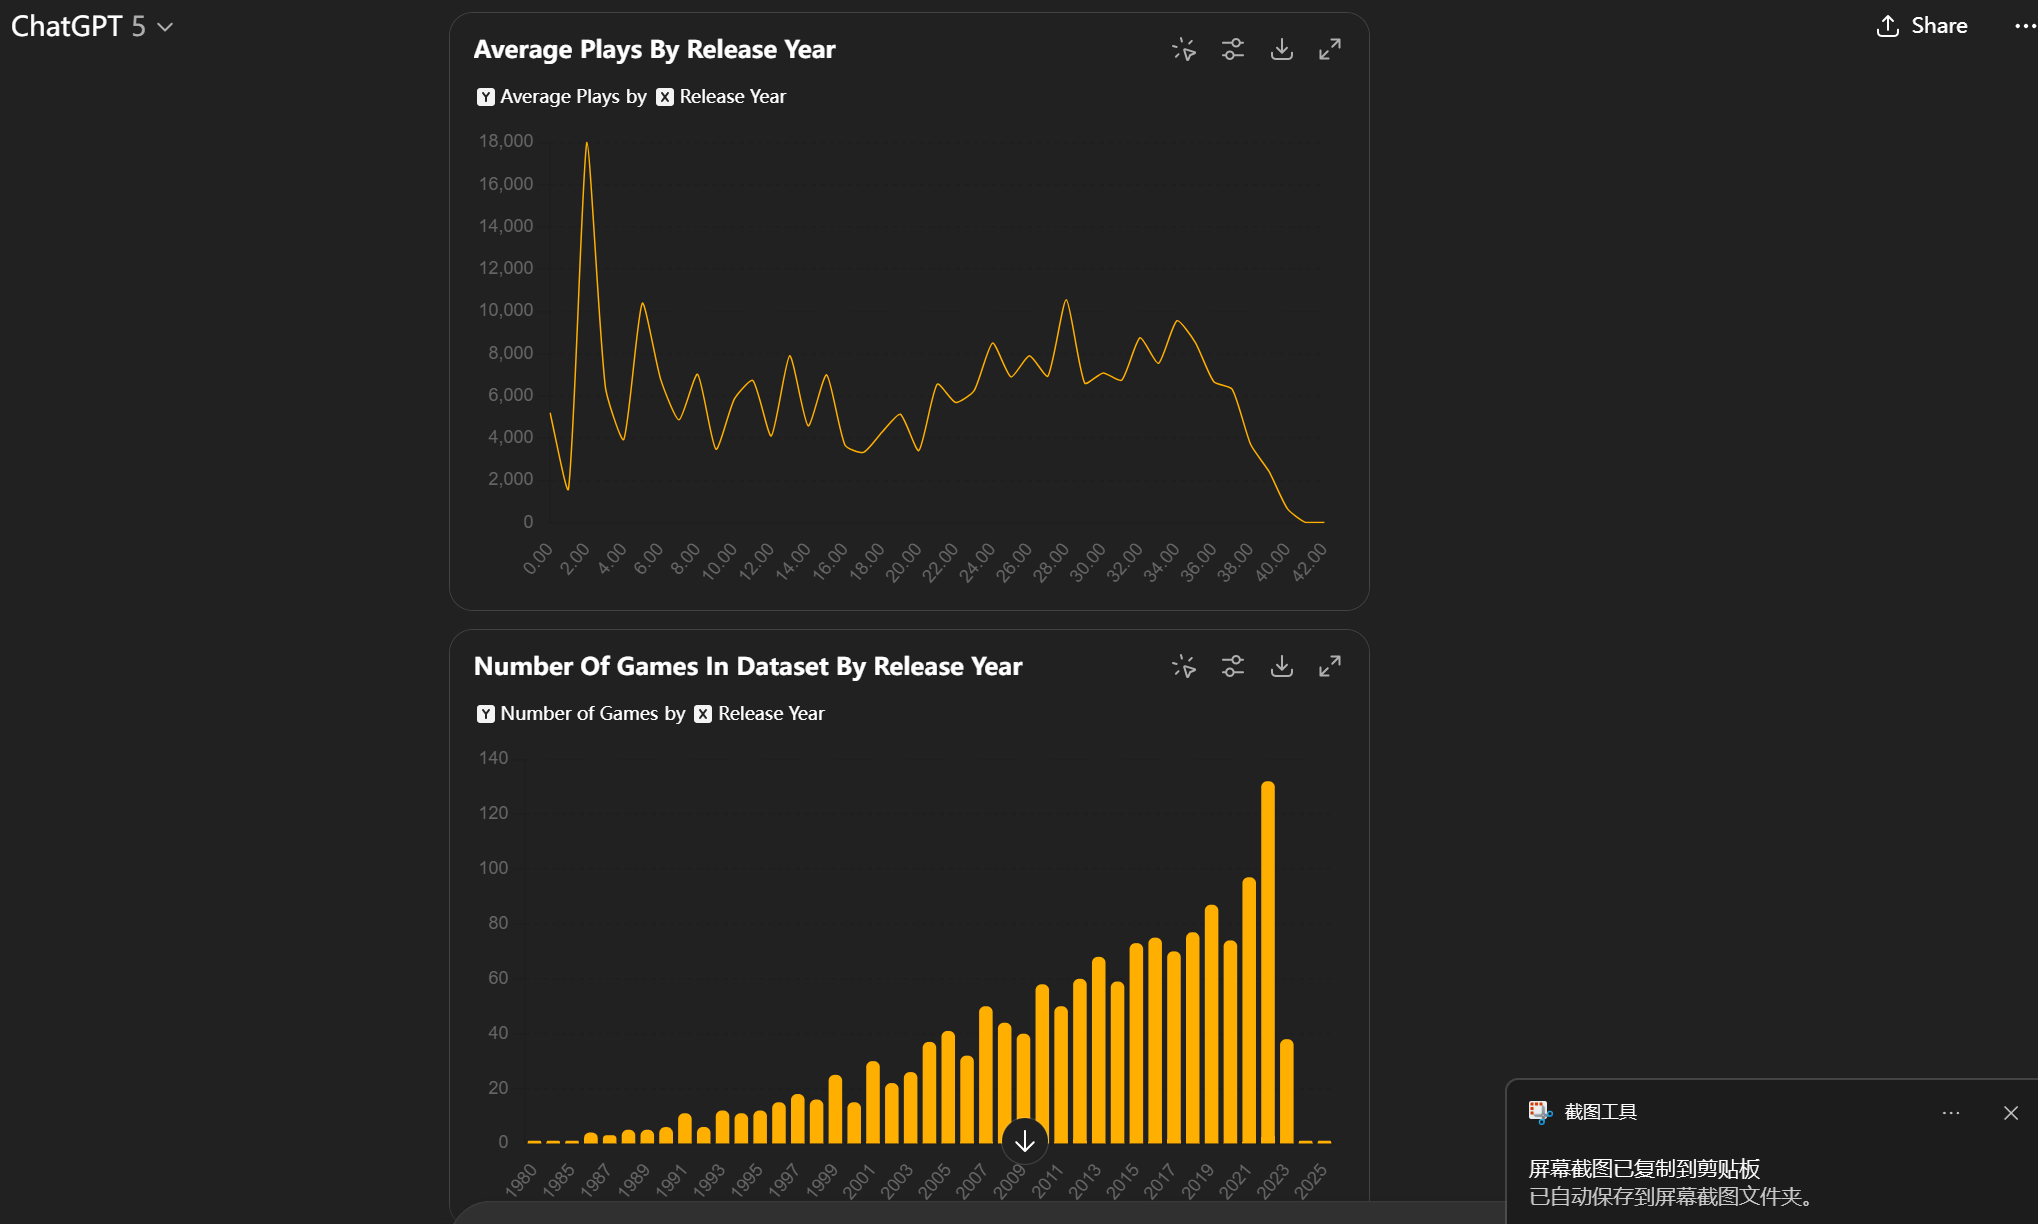

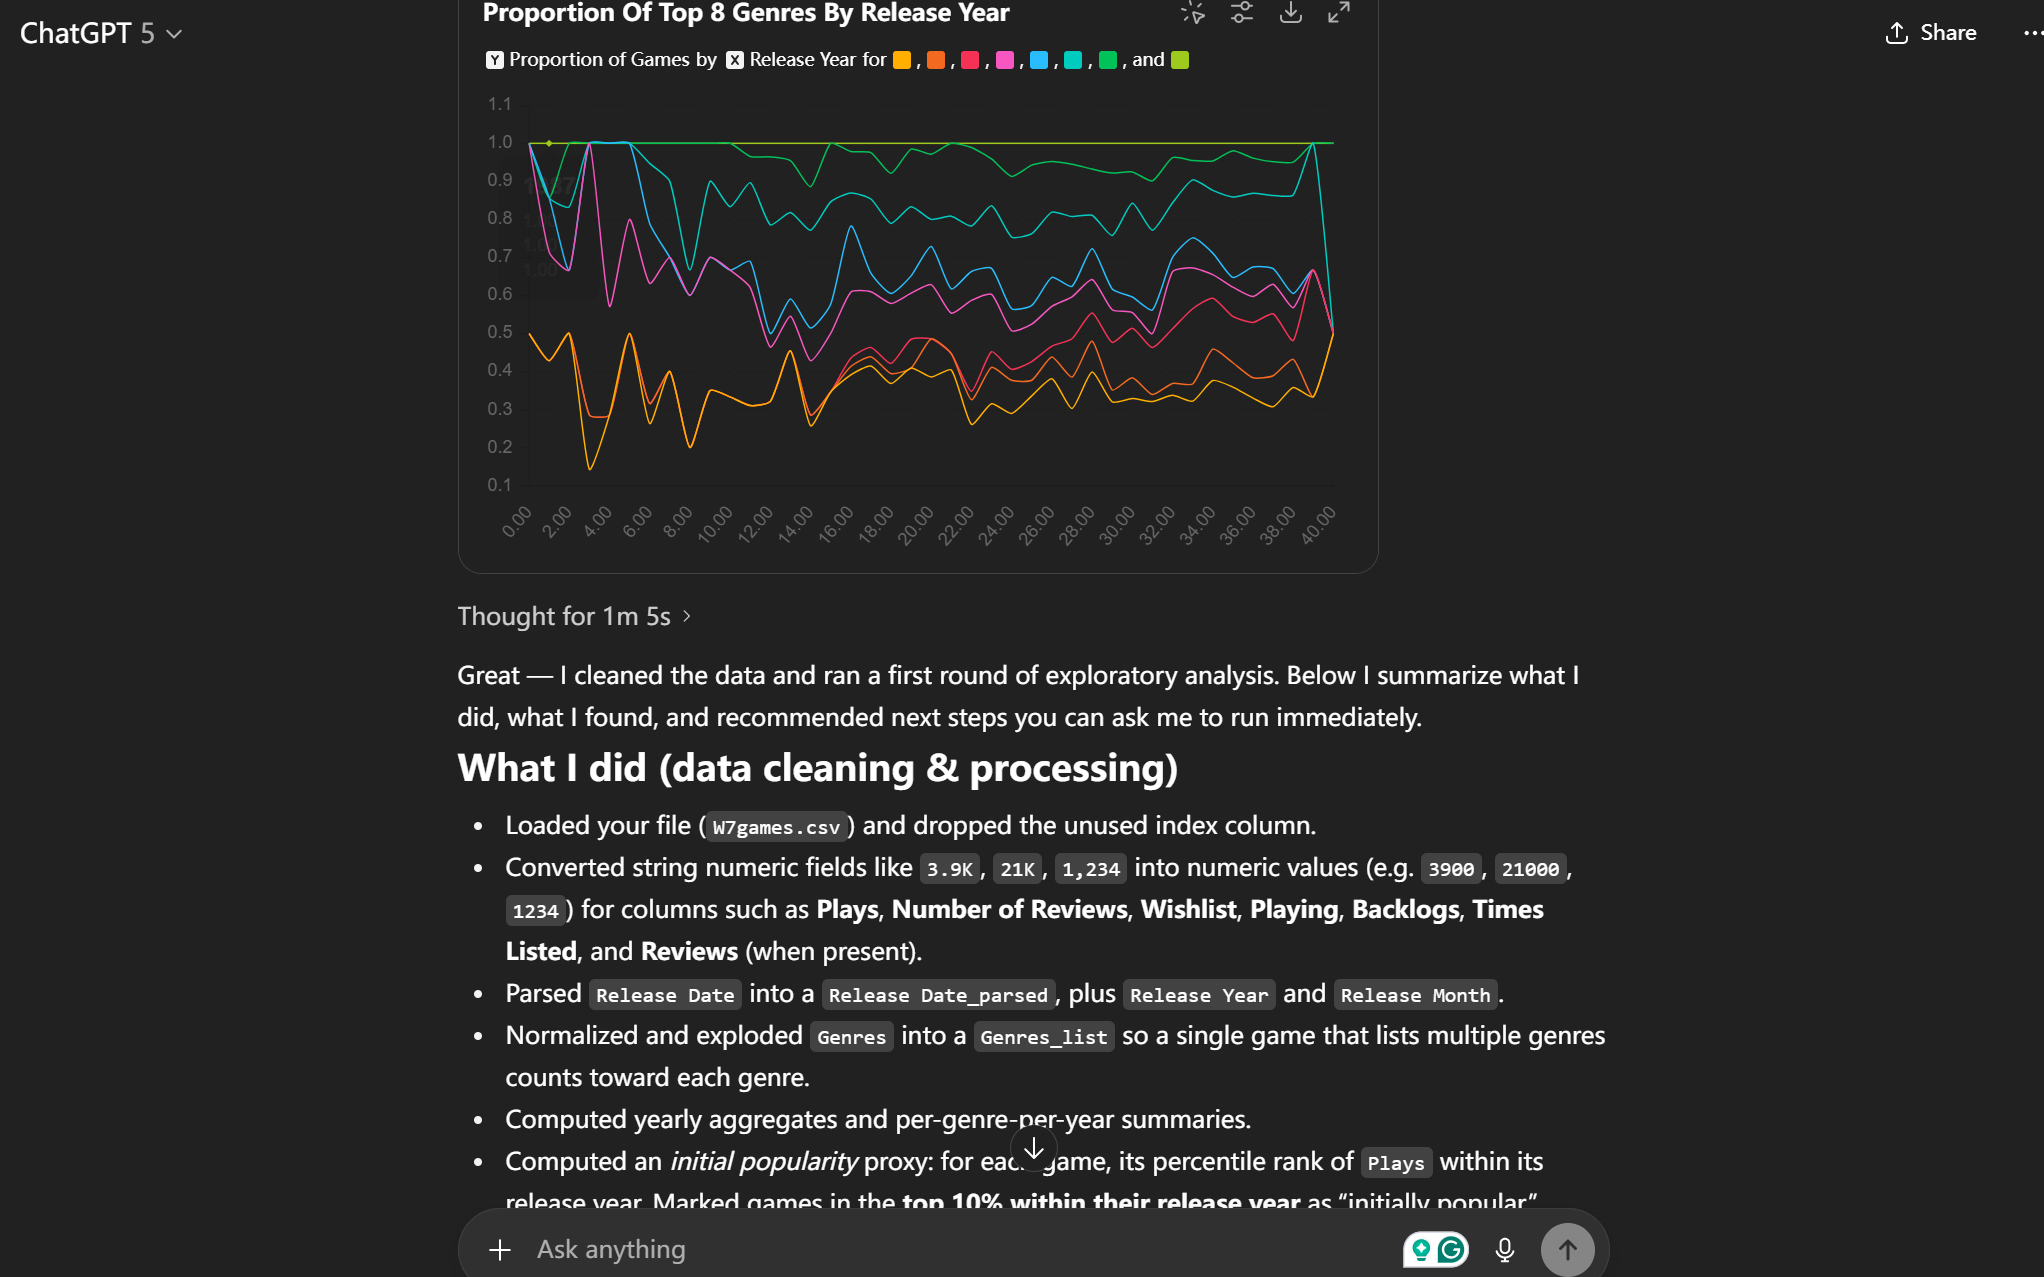

I think ChatGPT is much better at interpreting text data like sentiment values. It came up with almost the same top frequency words ('like', 'really', 'story', 'time', 'just', 'games', 'fun', 'good'...). And it went one more step with qualitative analysis, generating average sentiment/genre, which is similar to what I have done - sentiment for each genre and see if there are certain genre that have higher negative sentiment rather than positive. One thing interesting that ChatGPT did is that it figured out that there are non-english reviews as some words like que, jogo, um, não, la, el, que, es, juego showed up as top words. I tried to take out the filler words with my analysis but did not take into count there are other languages. This reminds me that if in the future, I will need to check and translate all languages to one and analyze accordingly.

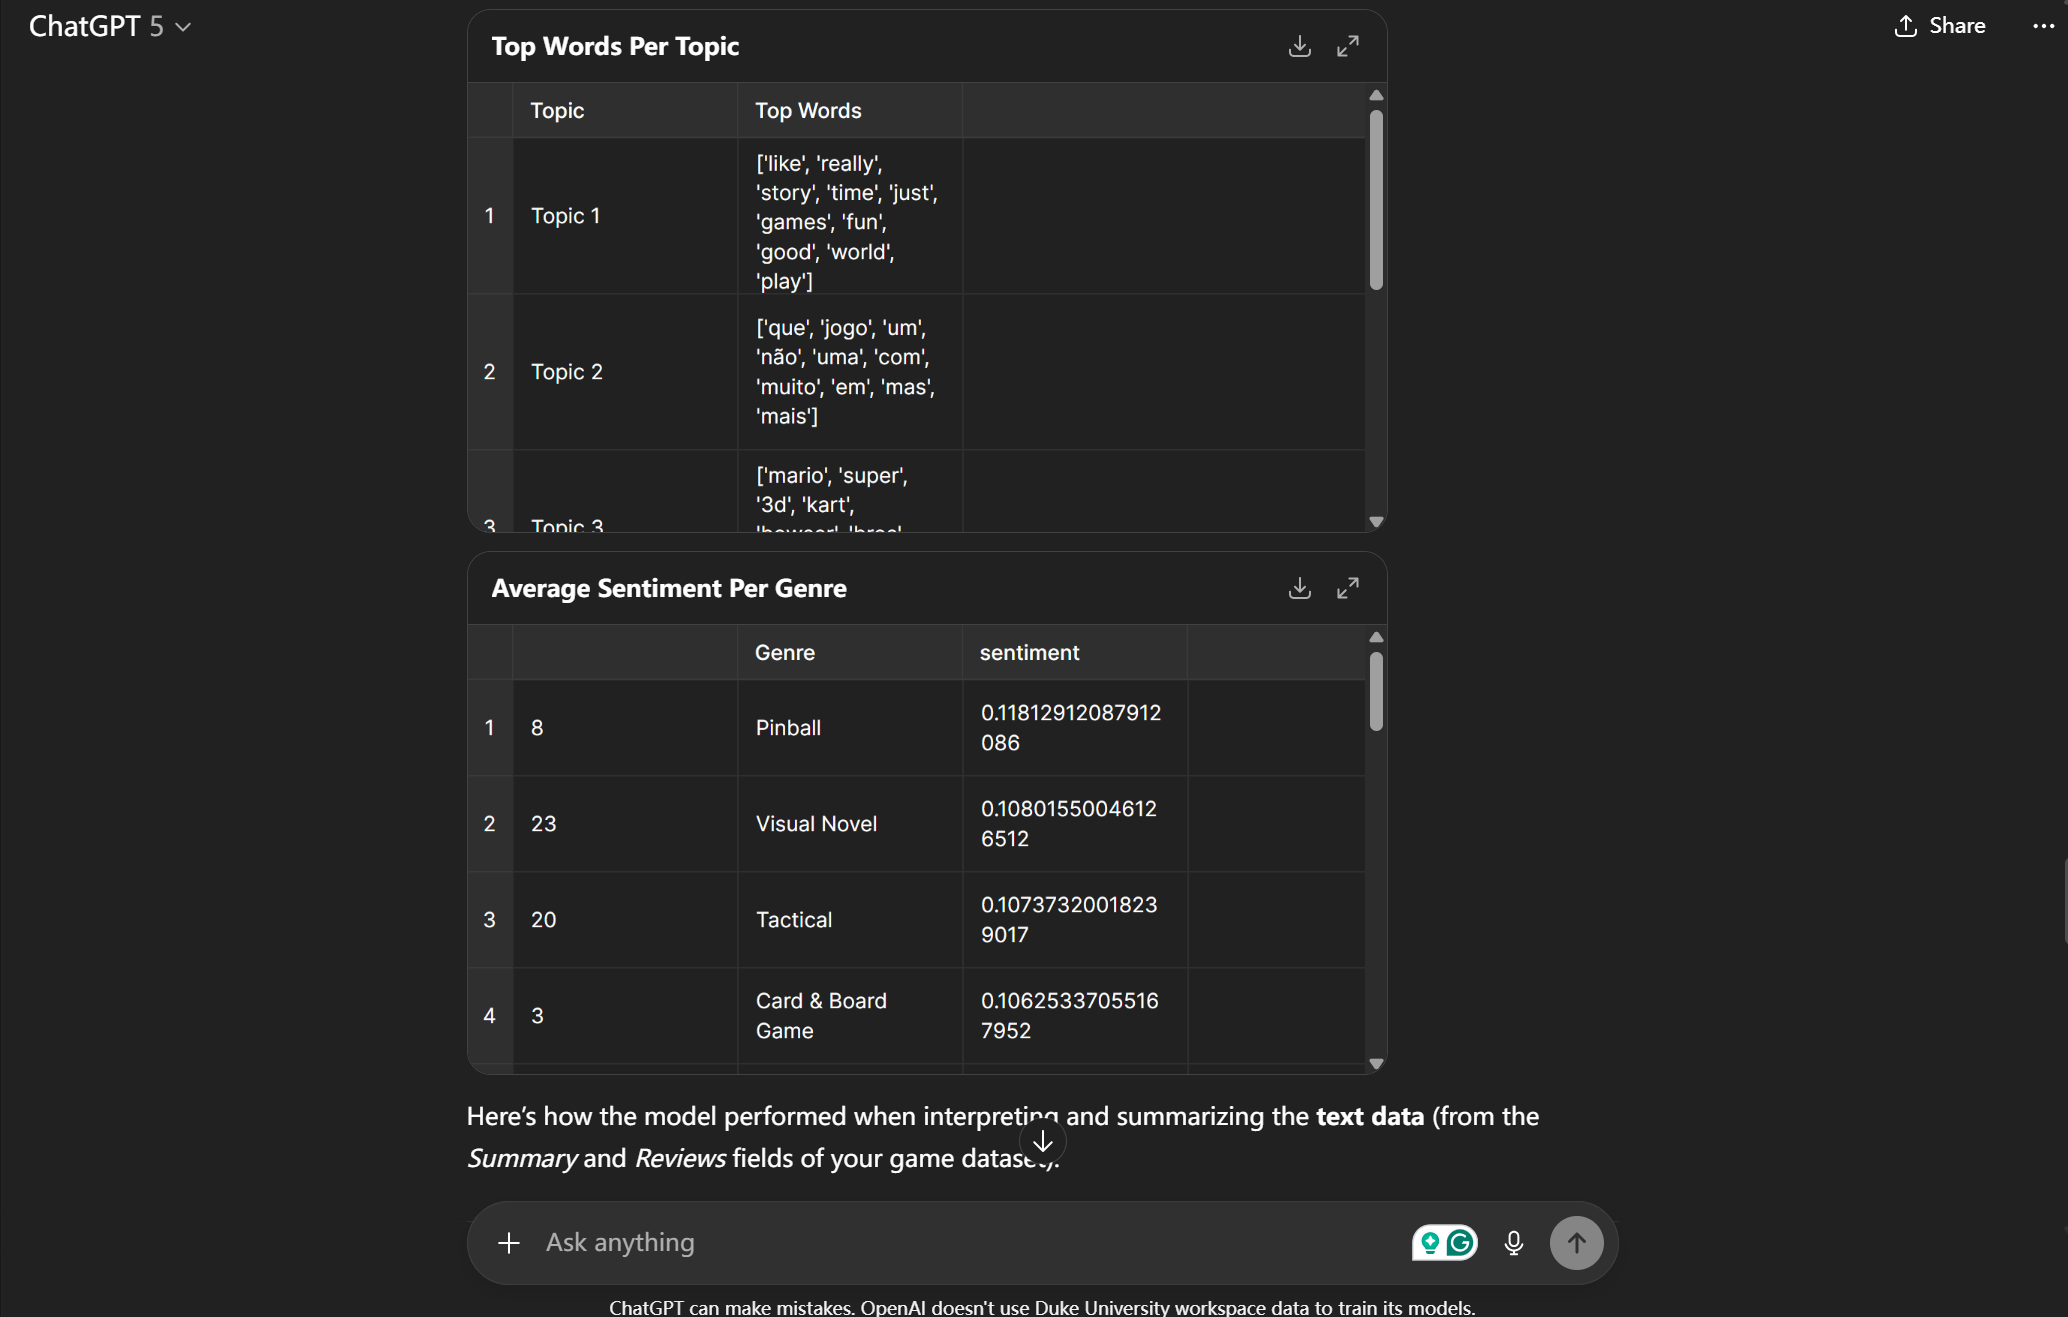

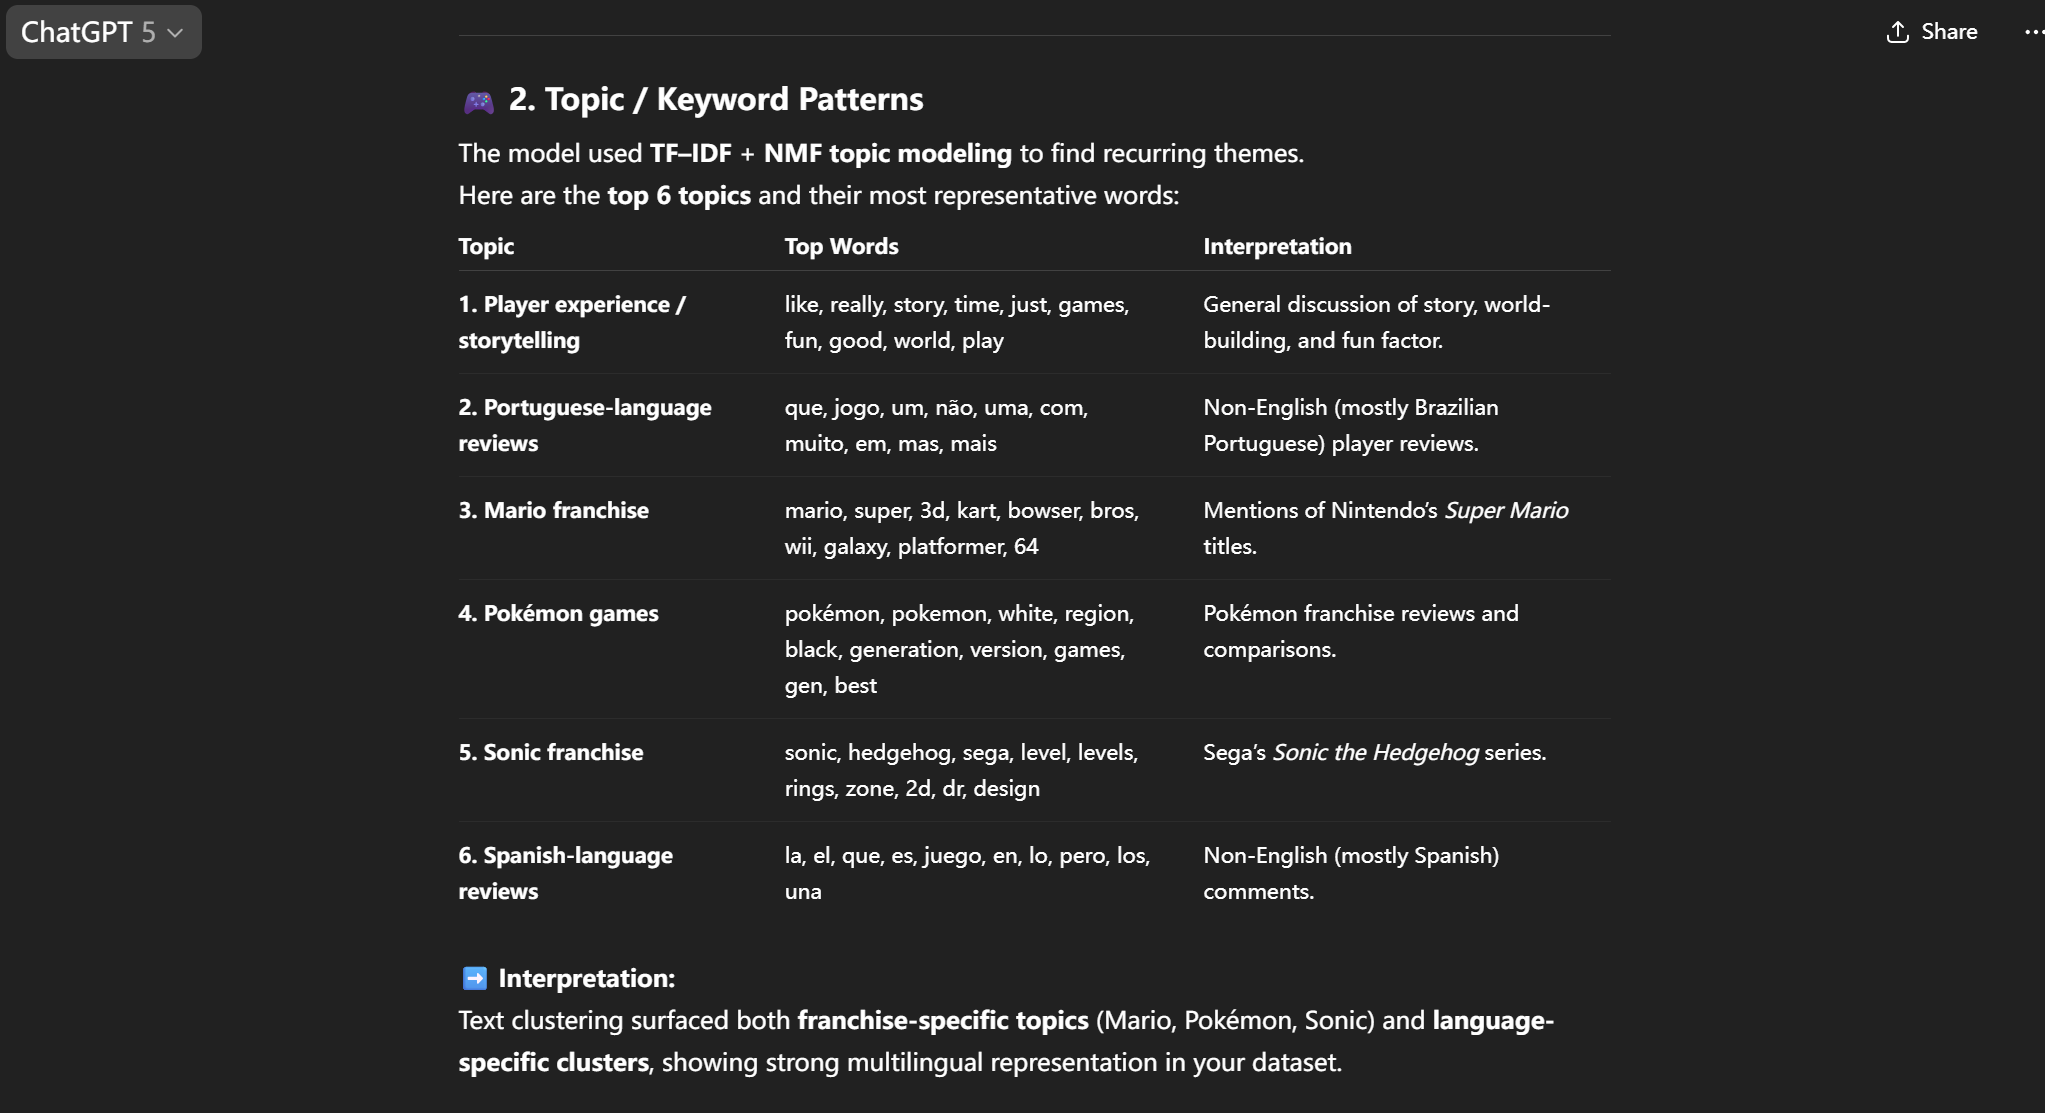